In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm # User for show the image sacaling
import os # using for gettiong the path of image

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, classification_report, multilabel_confusion_matrix, ConfusionMatrixDisplay
from glob import glob # getting the image path from directory.

import tensorflow as tf
import tensorflow.keras.layers as Layers
from tensorflow.keras import backend as K
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3
from tensorflow.keras.layers import GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation, Concatenate, Input
from keras.models import Model, load_model, Sequential
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from scikeras.wrappers import KerasClassifier

import matplotlib.gridspec as gridspec # using for build CM Axes object from the SubplotSpec
from sklearn.utils.class_weight import compute_class_weight

In [2]:
def visualize_training(history, lw = 3):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['accuracy'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_accuracy'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Accuracy vs Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(fontsize = 'x-large')
    plt.show()

    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label = 'training', marker = '*', linewidth = lw)
    plt.plot(history.history['val_loss'], label = 'validation', marker = 'o', linewidth = lw)
    plt.title('Training Loss vs Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(fontsize = 'x-large')
    plt.show()

def get_roc_curve(labels, true_vals, predicted_vals, when=''):
    auc_roc_vals = []
    for i in range(len(labels)):
        try:
            gt = true_vals[:, i]
            pred = predicted_vals[:, i]
            auc_roc = roc_auc_score(gt, pred)
            auc_roc_vals.append(auc_roc)
            fpr_rf, tpr_rf, _ = roc_curve(gt, pred)
            plt.figure(1, figsize=(10, 10))
            plt.plot([0, 1], [0, 1], 'k--')
            plt.plot(fpr_rf, tpr_rf, label=labels[i] + " (" + str(round(auc_roc, 3)) + ")")
            plt.xlabel('False positive rate')
            plt.ylabel('True positive rate')
            plt.title('ROC curve ' + when)
            plt.legend(loc='best')
        except ValueError as e:
            print(f"Error in generating ROC curve for {labels[i]}. Dataset lacks enough examples or encountered an error: {str(e)}")
    plt.show()
    return auc_roc_vals

In [3]:
IMAGE_SIZE=[128, 128] # 224
EPOCHS = 20
BATCH_SIZE = 32
RANDOM_STATE = 3 #1993
nRowsRead = 8192
SEED = 7

In [ ]:
data_main_dir = 'Main_Path_to_dataset'

# Get csv data from file and predicted labels except first two.
train_df_main = pd.read_csv(data_main_dir+'file_name.csv', delimiter=',', nrows = nRowsRead)
train_df_main.drop(['No Finding'], axis = 1, inplace = True)
labels = train_df_main.columns[2:]

# Get all images path using glob import 
image_paths = glob(data_main_dir+ 'Images/*.png')

# Split data in train, valid and test dataset
train_and_valid_set, test_set = train_test_split(train_df_main, test_size = 0.2, random_state = RANDOM_STATE)
train_set, valid_set = train_test_split(train_and_valid_set, test_size = 0.2, random_state = RANDOM_STATE)

# Concatenate FilePath based on the ImageIndex and make a FilePath column in datasets
Index =[]
for path in image_paths:
    Index.append(os.path.basename(path))
index_path_map = pd.DataFrame({'Image Index':Index, 'FilePath': image_paths})
index_path_map.head()

train_set = pd.merge(train_set, index_path_map, on='Image Index', how='left')
valid_set = pd.merge(valid_set, index_path_map, on='Image Index', how='left')
test_set = pd.merge(test_set, index_path_map, on='Image Index', how='left')

# print(f'Total image files found : {len(image_paths)}')
# print(f'Total number of image labels: {train_df_main.shape[0]}')
# print(f'Unique patients: {len(train_df_main["Patient ID"].unique())}')
print(f'*********************************')
print(f'Main datafram with all data : {train_df_main.shape}')
print(f'train_and_valid_set  : {train_and_valid_set.shape}')
print(f'test_set  : {test_set.shape}')
print(f'train_set  : {train_set.shape}')
print(f'valid_set  : {valid_set.shape}')

# Remove duplicates
train_set = train_set.drop_duplicates()
valid_set = valid_set.drop_duplicates()
test_set = test_set.drop_duplicates()

*********************************
Main datafram with all data : (8192, 16)
train_and_valid_set  : (6553, 16)
test_set  : (1639, 17)
train_set  : (5242, 17)
valid_set  : (1311, 17)


# Data Augmentation

In [5]:
# # Compute class weights for each label individually
# def class_weight_dict__fun(dataset):
#     class_weights_dict = {}
#     for label in labels:
#         class_weights = compute_class_weight('balanced', classes=np.unique(dataset[label]), y=dataset[label])
#         class_weights_dict[label] = dict(enumerate(class_weights))
#     return class_weights_dict

# # Function to compute sample weights
# def compute_sample_weights(df, class_weights_dict, labels):
#     sample_weights = np.ones(df.shape[0])
#     for label in labels:
#         class_weights = class_weights_dict[label]
#         sample_weights *= df[label].apply(lambda x: class_weights[int(x)]).values
#     return sample_weights

# # Compute sample weights for the training data
# train_set['sample_weights'] = compute_sample_weights(train_set, class_weight_dict__fun(train_set), labels)
# valid_set['sample_weights'] = compute_sample_weights(valid_set, class_weight_dict__fun(valid_set), labels)

In [6]:
def get_train_generator(df, image_dir, x_col, y_cols,sample_weight_col, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True, 
        shear_range=0.1,
        zoom_range=0.15,
        rotation_range=32,
        width_shift_range=0.1,
        height_shift_range=0.05,
        horizontal_flip=True, 
        vertical_flip = False, 
        brightness_range=(0.8, 1.2),
        channel_shift_range=0.1,
        rescale=1./255,
        fill_mode = 'reflect' # It should be (nearest,reflect)
    )
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            # weight_col=sample_weight_col,
            class_mode="raw",
            color_mode='rgb', 
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols,sample_weight_col, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=image_dir, 
        x_col="FilePath", 
        y_col=labels, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.__next__()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True,
        rescale=1./255)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            # weight_col=sample_weight_col,
            class_mode="raw",
            color_mode='rgb',
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            color_mode='rgb',
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [7]:
train_generator = get_train_generator(df = train_set,
                                      image_dir = '', 
                                      x_col = "FilePath",
                                      y_cols = labels, 
                                      sample_weight_col='sample_weights',
                                      batch_size=BATCH_SIZE,
                                      target_w = IMAGE_SIZE[0], 
                                      target_h = IMAGE_SIZE[1] 
                                      )

valid_generator, test_generator= get_test_and_valid_generator(valid_df = valid_set, 
                                                              test_df = test_set, 
                                                              train_df = train_set,
                                                              image_dir = '', 
                                                              x_col = "FilePath", 
                                                              y_cols = labels,
                                                              sample_weight_col='sample_weights',
                                                              batch_size = BATCH_SIZE,
                                                              target_w = IMAGE_SIZE[0], 
                                                              target_h = IMAGE_SIZE[1])

Found 5242 validated image filenames.
Found 5242 validated image filenames.
Found 1311 validated image filenames.
Found 1639 validated image filenames.


# Data Visualization

  0%|          | 0/12 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats

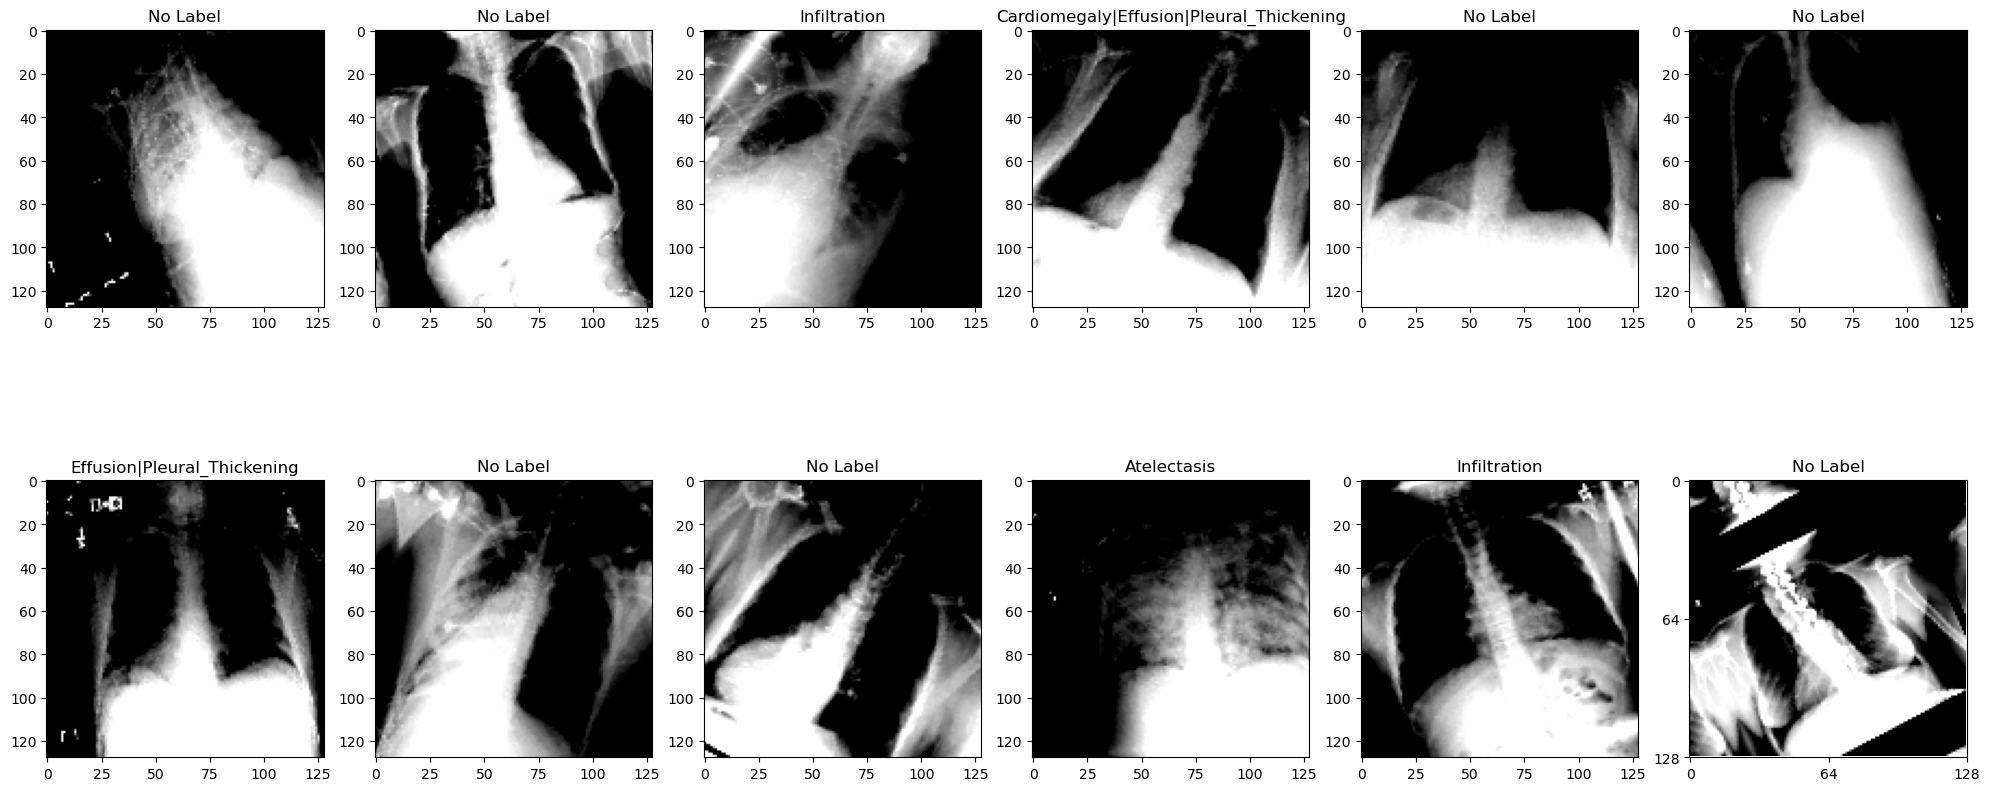

In [8]:
def get_label(y):
    ret_labels = []
    i = 0
    for idx in y:
        if idx:
            ret_labels.append(labels[i])
        i += 1
    if not ret_labels:
        return 'No Label'
    else:
        return '|'.join(ret_labels)

# get one batch of images from the imageset    
x, y = train_generator.__getitem__(0)

#show a set of images along with the labels appended at the top as title.
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
for i in tqdm(range(12)):
    axs[i//6, i%6].imshow(x[i], cmap = 'gray')
    axs[i//6, i%6].set_title(get_label(y[i-1]))
    axs[i//6, i%6].axis('on')  # Turn on axis

plt.xticks([0, x[0].shape[1]//2, x[0].shape[1]])  # Set x-axis ticks
plt.yticks([0, x[0].shape[0]//2, x[0].shape[0]])  # Set y-axis ticks
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust spacing between subplots
plt.tight_layout()  # Ensure labels fit within plot area
plt.show()

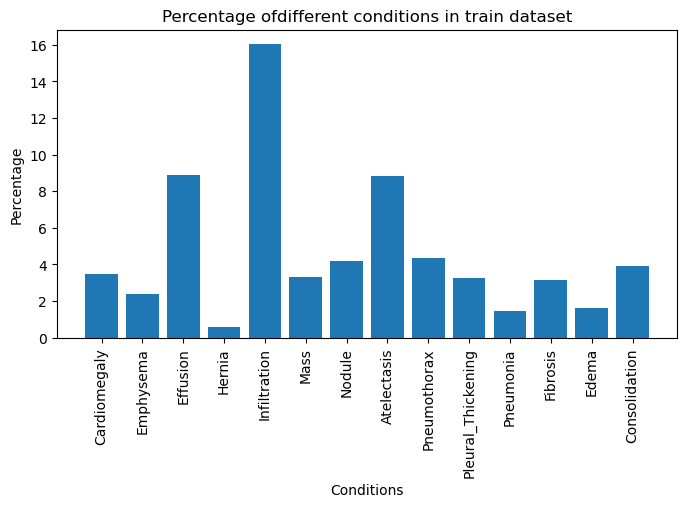

In [9]:
plt.figure(figsize=(8,4))
plt.xticks(rotation = 90)
plt.bar(labels, train_generator.labels.sum(axis = 0)/train_generator.n * 100)
plt.title('Percentage ofdifferent conditions in train dataset')
plt.xlabel('Conditions')
plt.ylabel('Percentage')
plt.show()

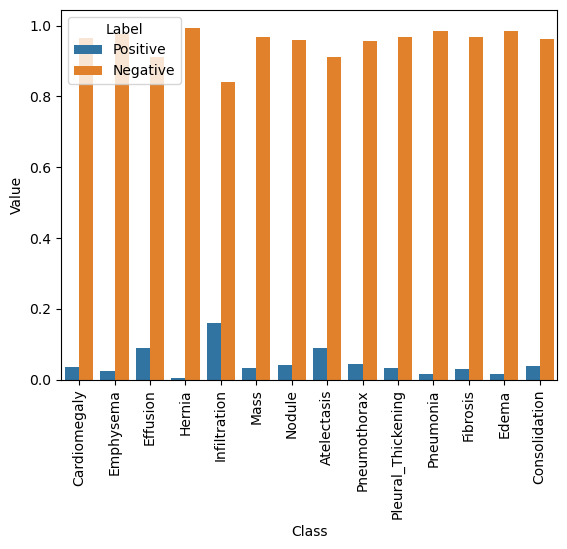

In [10]:
def compute_class_freqs(labels):
    # total number of patients (rows)
    N = labels.shape[0]
    positive_frequencies = (labels.sum(axis = 0))/N
    negative_frequencies = 1.0 - positive_frequencies
    return positive_frequencies, negative_frequencies

# calulating and plotting the imbalanced classes
freq_pos, freq_neg = compute_class_freqs(train_generator.labels)
data_pos = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": freq_pos})
data_neg = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(freq_neg)])

# Combining both DataFrames
data = pd.concat([data_pos, data_neg], ignore_index=True)
plt.xticks(rotation=90)
f = sns.barplot(x="Class", y="Value", hue="Label" ,data=data)

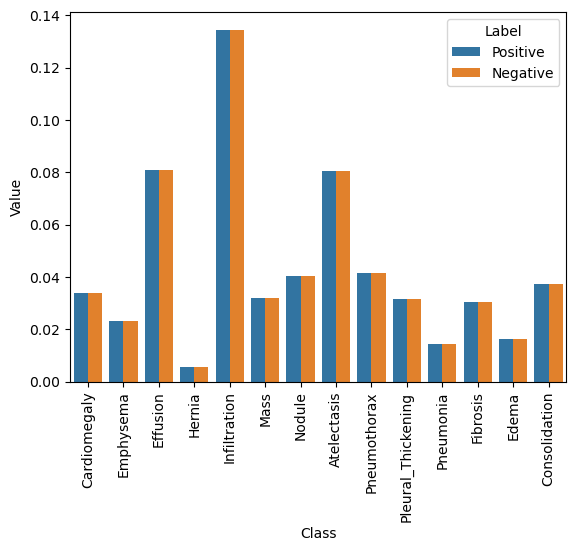

In [11]:
pos_weights = freq_neg
neg_weights = freq_pos
pos_contribution = freq_pos * pos_weights 
neg_contribution = freq_neg * neg_weights
pos_weights

data_1 = pd.DataFrame({"Class": labels, "Label": "Positive", "Value": pos_contribution})
data_2 = pd.DataFrame([{"Class": labels[l], "Label": "Negative", "Value": v} for l,v in enumerate(neg_contribution)])
data = pd.concat([data_1, data_2], ignore_index=True)
plt.xticks(rotation=90)
sns.barplot(x="Class", y="Value", hue="Label" ,data=data);

# Models Building

In [12]:
# def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
#     def weighted_loss(y_true, y_pred):
#         # initialize loss to zero
#         loss = 0.0
        
#         for i in range(len(pos_weights)):
#             # for each class, add average weighted loss for that class 
#             loss_pos = -1 * K.mean(pos_weights[i] * y_true[:, i] * K.log(y_pred[:, i] + epsilon))
#             loss_neg = -1 * K.mean(neg_weights[i] * (1 - y_true[:, i]) * K.log(1 - y_pred[:, i] + epsilon))
#             loss += loss_pos + loss_neg
#         return loss

#     return weighted_loss
    
def build_lrfn(lr_start=0.000002, lr_max=0.00010, lr_min=0, lr_rampup_epochs=8, lr_sustain_epochs=0, lr_exp_decay=.8):

    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) *\
                 lr_exp_decay**(epoch - lr_rampup_epochs\
                                - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

lrfn = build_lrfn()
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

#### Searching best parameters

In [13]:
""" 
This function searching best parameters for models.
Searching parameters is batch size and epochs
"""
def get_batch_parameter(search_model):
    # fix random seed for reproducibility
    tf.random.set_seed(SEED)

    # create model
    model = KerasClassifier(model=search_model, verbose=0)
    # define the grid search parameters
    batch_size = [10, 20, 40, 60, 80]
    epochs = [10, 15, 20]
    
    param_grid = dict(batch_size=batch_size, epochs=epochs)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=12, n_jobs=-1, cv=5)
    batches_x, batches_y = train_generator.__getitem__(0)
    grid_result = grid.fit(batches_x, batches_y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    # means = grid_result.cv_results_['mean_test_score']
    # stds = grid_result.cv_results_['std_test_score']
    # params = grid_result.cv_results_['params']
    # for mean, stdev, param in zip(means, stds, params):
    #     print("%f (%f) with: %r" % (mean, stdev, param))

    return grid_result.best_params_

""" 
This function searching best parameters for models.
Searching parameters is optimizer, learning rate, init mode, activation, dropout rate
"""
def get_parameters_using_bacth(search_model, batch=10, epoch=10):
    # fix random seed for reproducibility
    tf.random.set_seed(SEED)
    
    # create model
    model = KerasClassifier(model=search_model, loss="binary_crossentropy", epochs=epoch, batch_size=batch, verbose=0)
    
    # define the grid search parameters
    optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
    learn_rate = [0.00001, 0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]
    init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
    activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
    dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    # neurons = [1, 5, 10, 15, 20, 25, 30] , model__neurons=neurons
    
    param_grid = dict(optimizer=optimizer, optimizer__learning_rate=learn_rate, model__init_mode=init_mode, model__activation=activation, model__dropout_rate=dropout_rate)
    grid = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=15, n_jobs=-1, cv=5)

    x, y = train_generator.__getitem__(0)
    grid_result = grid.fit(x, y)
    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    return grid_result.best_params_

# function return the optimizer based on the value.
def get_optimizer(value):
    optimizer = None
    
    if value == 'SGD':
        optimizer = SGD
    elif value == 'RMSprop':
        optimizer = RMSprop
    elif value == 'Adagrad':
        optimizer = Adagrad
    elif value == 'RMSprop':
        optimizer = Adadelta
    elif value == 'Adadelta':
        optimizer = RMSprop
    elif value == 'Adam':
        optimizer = Adam
    elif value == 'Adamax':
        optimizer = Adamax
    elif value == 'Nadam':
        optimizer = Nadam

    return optimizer

### Inception Model

In [14]:
# Step 1: Adapt the create_model function
def inception_model(optimizer='Adam', init_mode='uniform', activation='relu', dropout_rate=0.5, connected_activation='sigmoid', learn_rate = 0.01, isCompile = False):
     # Input layer
    inputs = Input(shape=(*IMAGE_SIZE, 3))

    # Use InceptionV3 as the base model
    inception_base_model = InceptionV3(include_top=False, weights='imagenet', input_tensor=inputs)
    
    # Freeze the layers of the base model
    inception_base_model.trainable = False

    # Add GlobalAveragePooling2D layer
    x = inception_base_model.output
    x = GlobalAveragePooling2D()(x)

    # Add additional dense and dropout layers for robustness
    x = Dense(64, activation=activation, kernel_initializer=init_mode)(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(128, activation=activation, kernel_initializer=init_mode)(x)
    x = Dropout(dropout_rate)(x)

    x = Dense(512, activation=activation, kernel_initializer=init_mode)(x)
    x = Dropout(dropout_rate)(x)

    # Flatten and fully-connected layers
    x = Flatten()(x)
    x = Dense(1024, activation=activation, kernel_initializer=init_mode)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(len(labels), activation=connected_activation)(x)  # Change to 'sigmoid' if it's binary classification

    # Define the model
    model = Model(inputs=inputs, outputs=x)

    optimizer_class = get_optimizer(optimizer)
    # Compile the model
    if isCompile:
        model.compile(optimizer=optimizer_class(learning_rate=learn_rate), loss='binary_crossentropy', metrics=['accuracy'])
    else:
        model.compile(optimizer=optimizer_class(), loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [15]:
inception_best_batch_param = get_batch_parameter(inception_model)
inception_batch_size = inception_best_batch_param['batch_size']
inception_epoch = inception_best_batch_param['epochs']
inception_best_param = get_parameters_using_bacth(search_model=inception_model , batch=inception_batch_size, epoch=inception_epoch)

C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.657143 using {'epochs': 15, 'batch_size': 10}


C:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best: 0.657143 using {'optimizer__learning_rate': 1e-05, 'optimizer': 'SGD', 'model__init_mode': 'uniform', 'model__dropout_rate': 0.0, 'model__activation': 'softsign'}


In [16]:
# Define best parameters for the model
inception_optimizer = inception_best_param['optimizer']
inception_init_mode = inception_best_param['model__init_mode']
inception_activation = inception_best_param['model__activation']
inception_dropout_rate = inception_best_param['model__dropout_rate']
inception_connected_activation = 'sigmoid'
inception_learning_rate = inception_best_param['optimizer__learning_rate']

# call resnet function for model
model = inception_model(
    optimizer=inception_optimizer,
    init_mode=inception_init_mode,
    activation=inception_activation,
    dropout_rate=inception_dropout_rate,
    connected_activation = inception_connected_activation,
    learn_rate = inception_learning_rate,
    isCompile = True)
    

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_188 (Conv2D) │ (None, 63, 63,    │        864 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 63, 63,    │         96 │ conv2d_188[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 63, 63,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 61, 61,    │      9,216 │ activation_188[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │         96 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 61, 61,    │     18,432 │ activation_189[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 61, 61,    │        192 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_190      │ (None, 61, 61,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 30, 30,    │          0 │ activation_190[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 30, 30,    │      5,120 │ max_pooling2d_8[… │
│                     │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 30,    │        240 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_191      │ (None, 30, 30,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 28, 28,    │    138,240 │ activation_191[0… │
│                     │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        576 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_192      │ (None, 28, 28,    │          0 │ batch_normalizat

 Total params: 22,547,950 (86.01 MB)

 Trainable params: 745,166 (2.84 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [17]:
predicted_vals_before = model.predict(test_generator, steps=len(test_generator))

C:\Users\asif\AppData\Roaming\Python\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


52/52 ━━━━━━━━━━━━━━━━━━━━ 50s 863ms/step


In [18]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=inception_epoch, 
    batch_size=inception_batch_size,
    verbose=1,
    callbacks=[lr_schedule]
)


Epoch 1: LearningRateScheduler setting learning rate to 2e-06.
Epoch 1/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 208s 1s/step - accuracy: 0.0134 - loss: 0.6913 - val_accuracy: 0.0206 - val_loss: 0.6912 - learning_rate: 2.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1.425e-05.
Epoch 2/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 192s 1s/step - accuracy: 0.0194 - loss: 0.6911 - val_accuracy: 0.0198 - val_loss: 0.6910 - learning_rate: 1.4250e-05

Epoch 3: LearningRateScheduler setting learning rate to 2.6500000000000004e-05.
Epoch 3/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 157s 935ms/step - accuracy: 0.0198 - loss: 0.6908 - val_accuracy: 0.0198 - val_loss: 0.6906 - learning_rate: 2.6500e-05

Epoch 4: LearningRateScheduler setting learning rate to 3.875000000000001e-05.
Epoch 4/15
164/164 ━━━━━━━━━━━━━━━━━━━━ 161s 955ms/step - accuracy: 0.0178 - loss: 0.6903 - val_accuracy: 0.0198 - val_loss: 0.6900 - learning_rate: 3.8750e-05

Epoch 5: LearningRateScheduler setting learning rate to 5.10000000000000

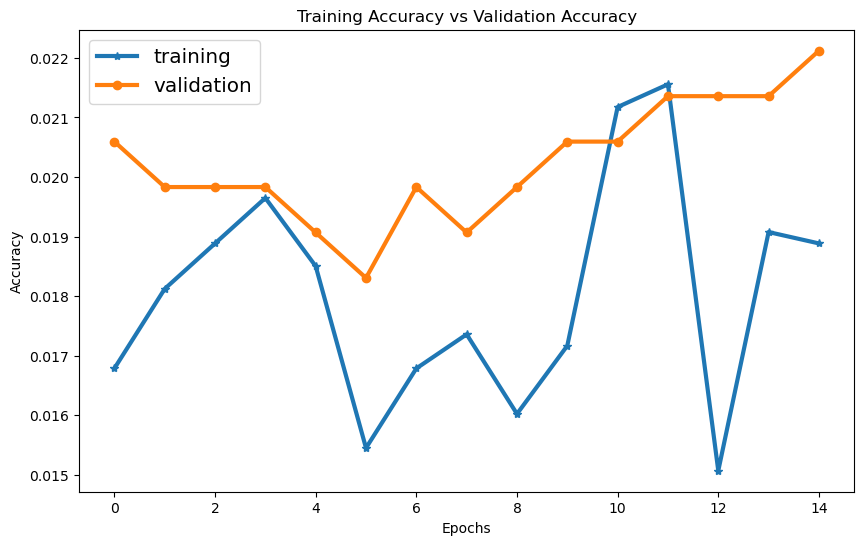

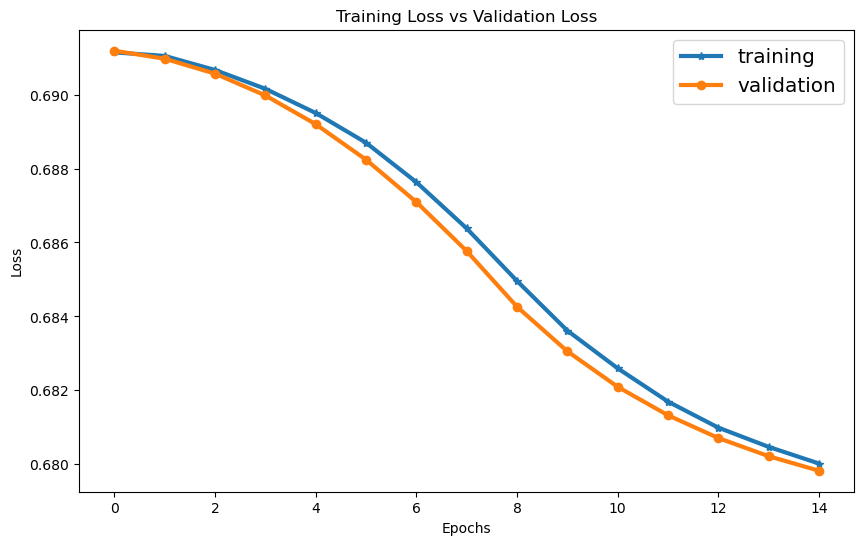

In [19]:
visualize_training(history)

In [20]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size, verbose=1)
print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

51/51 ━━━━━━━━━━━━━━━━━━━━ 34s 663ms/step - accuracy: 0.0174 - loss: 0.6800
Test Loss: 0.6800577640533447
Test Accuracy: 0.01715686358511448


52/52 ━━━━━━━━━━━━━━━━━━━━ 34s 648ms/step


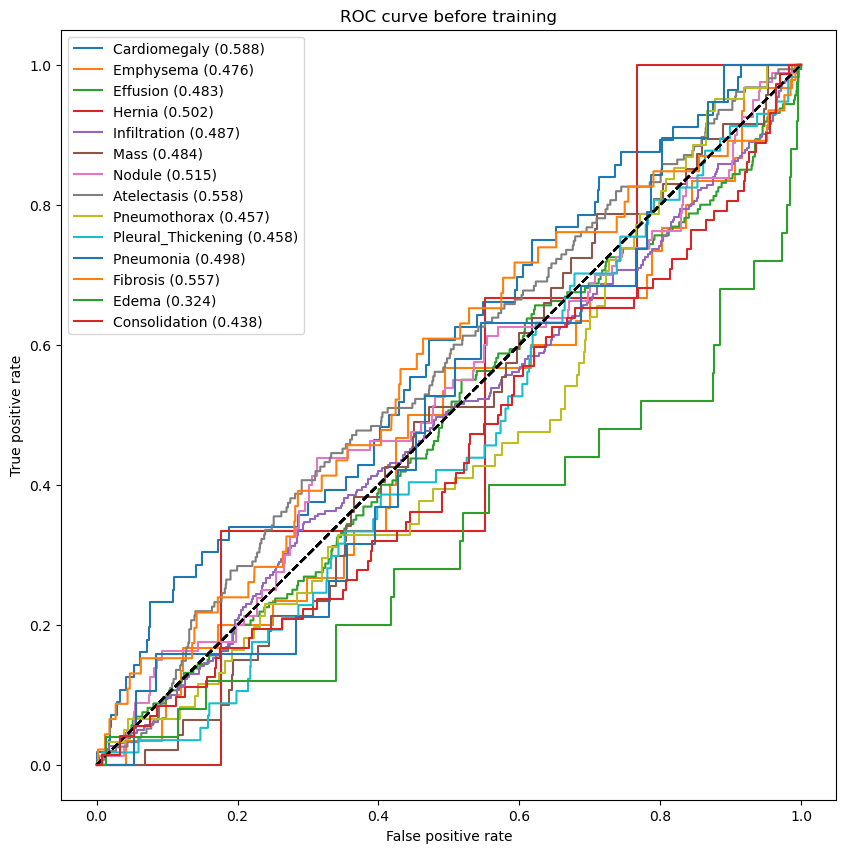

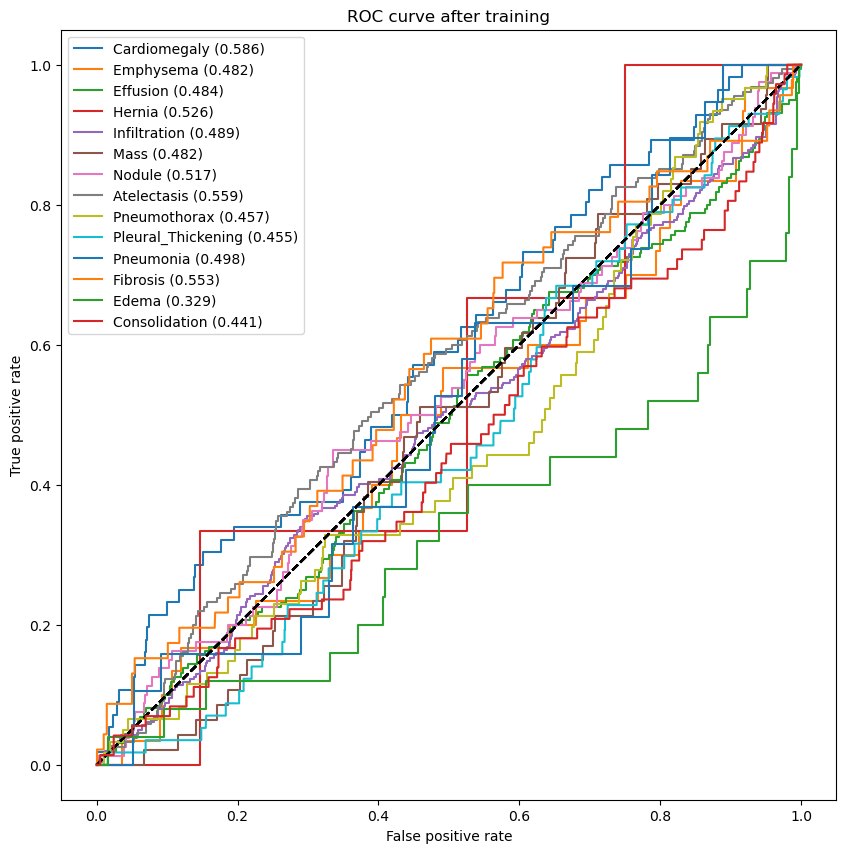

In [21]:
predicted_vals_after = model.predict(test_generator, steps=len(test_generator))
auc_rocs_before =get_roc_curve(labels, test_generator.labels, predicted_vals_before, when = 'before training')
auc_rocs_after = get_roc_curve(labels, test_generator.labels, predicted_vals_after, when='after training')

# Model Evaluation

In [22]:
# Make predictions on the test set
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
true_labels = np.argmax(test_generator.labels, axis=1)

# Compute evaluation metrics
f1 = f1_score(true_labels, predicted_labels, average='macro')
precision = precision_score(true_labels, predicted_labels, average='macro')
recall = recall_score(true_labels, predicted_labels, average='macro')
report = classification_report(true_labels, predicted_labels, target_names=labels)

# Print evaluation metrics
print(f'Accuracy: {test_accuracy}')
print(f'F1-Score: {f1}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print('Classification Report:')
print(report)

52/52 ━━━━━━━━━━━━━━━━━━━━ 35s 668ms/step
Accuracy: 0.01715686358511448
F1-Score: 0.010069346689420947
Precision: 0.04004754660295039
Recall: 0.09228241347507403
Classification Report:
                    precision    recall  f1-score   support

      Cardiomegaly       0.35      0.01      0.02       981
         Emphysema       0.00      0.00      0.00        30
          Effusion       0.14      0.01      0.01       135
            Hernia       0.00      0.00      0.00         3
      Infiltration       0.00      0.00      0.00       203
              Mass       0.02      0.33      0.03        30
            Nodule       0.00      0.00      0.00        58
       Atelectasis       0.00      0.00      0.00        77
      Pneumothorax       0.00      0.00      0.00        38
Pleural_Thickening       0.01      0.04      0.01        25
         Pneumonia       0.03      0.10      0.05        10
          Fibrosis       0.00      0.00      0.00        27
             Edema       0.00     

C:\Users\asif\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asif\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\asif\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

C:\Users\asif\AppData\Local\Temp\ipykernel_300\2110263897.py:18: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


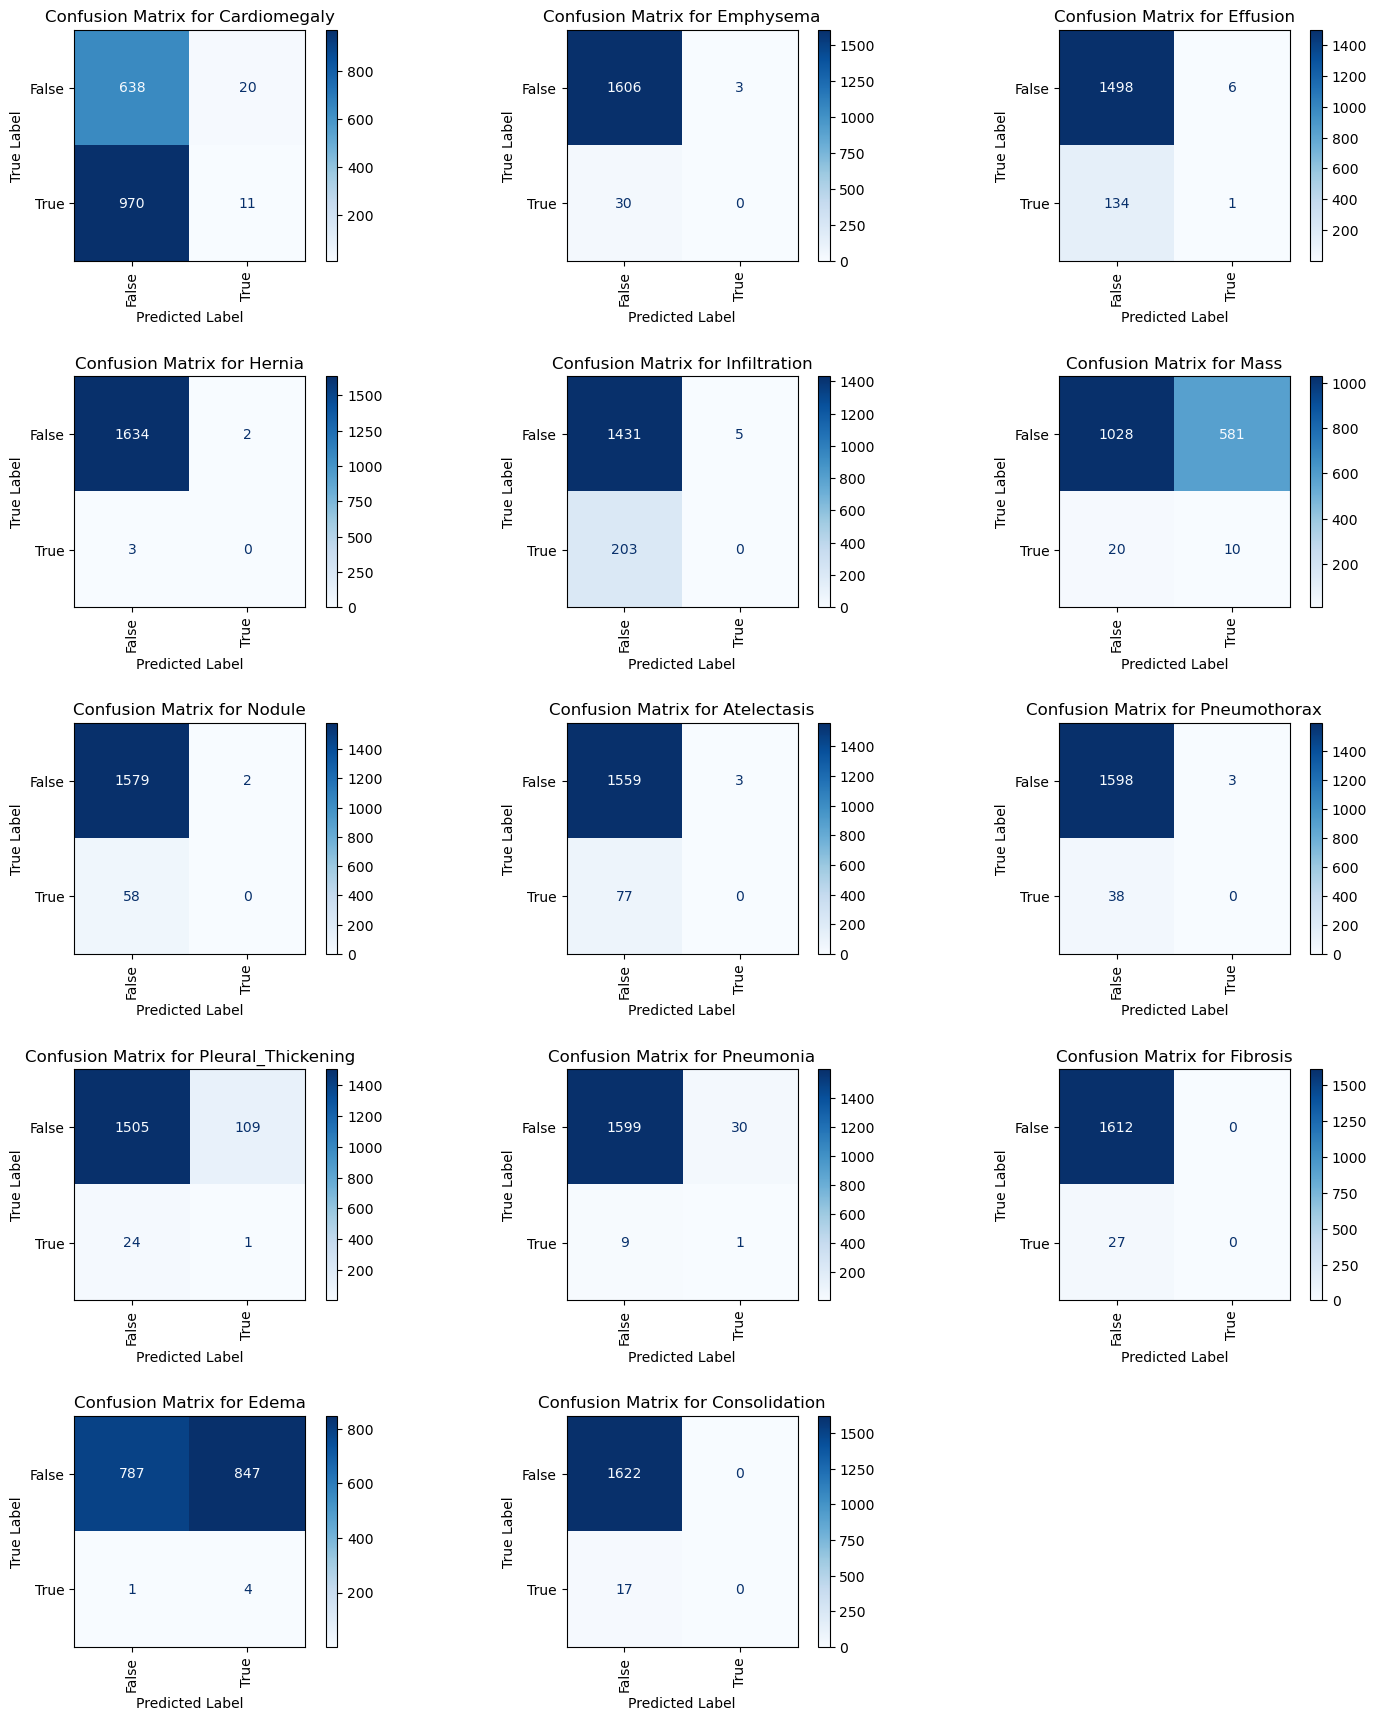

In [23]:
# Get confusion matrix for all labels
confusion_mtx = multilabel_confusion_matrix(true_labels, predicted_labels)

fig = plt.figure(figsize=(18, 30))
gs = gridspec.GridSpec(nrows=(len(labels) + 1) // 2, ncols=3, height_ratios=[1]*((len(labels) + 1) // 2), hspace=0.5)

for i in range(len(labels)):
    # Create an Axes object from the SubplotSpec
    ax = fig.add_subplot(gs[i])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mtx[i])
    disp.plot(cmap="Blues", ax=ax)
    ax.set_title(f'Confusion Matrix for {labels[i]}', fontsize=12)
    ax.set_xlabel('Predicted Label', fontsize=10)
    ax.set_ylabel('True Label', fontsize=10)
    ax.set_xticklabels(['False', 'True'], rotation=90, fontsize=10)
    ax.set_yticklabels(['False', 'True'], rotation=0, fontsize=10)

plt.tight_layout()
plt.show()
